In [1]:
from sklearn import datasets
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from sklearn.metrics import classification_report, accuracy_score
data = datasets.fetch_lfw_people(resize=1,min_faces_per_person=70)
X = data['data']
y = data['target']
faces = data['images']
target_names = data['target_names']
print(X.shape)
print(y.shape)
print(faces.shape)
print(target_names)

(1288, 11750)
(1288,)
(1288, 125, 94)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


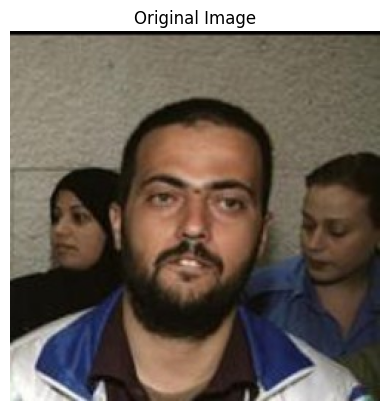

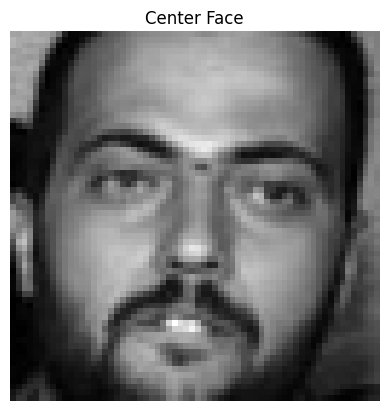

In [2]:
import cv2
import numpy as np

def get_center_face(image_path,target_size=(64, 64)):
    # load the picture 
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # load the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # detect faces
    faces = face_cascade.detectMultiScale(image)
    
    if len(faces) == 0:
        # print(image_path, 'no face detected') 
        return None

    image = gray
    # calculate the center of the image
    img_center = np.array([image.shape[1] // 2, image.shape[0] // 2])

    # find the closest face to the center
    closest_face = None
    min_distance = float('inf')
    
    for (x, y, w, h) in faces:
        face_center = np.array([x + w // 2, y + h // 2])
        distance = np.linalg.norm(face_center - img_center)
        
        if distance < min_distance:
            min_distance = distance
            closest_face = (x, y, w, h)
    
    # crop the face
    x, y, w, h = closest_face
    center_face = image[y:y+h, x:x+w]

    if center_face is not None:
        center_face = cv2.resize(center_face, target_size)
    
    return center_face

Image_path = 'lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg'
original = cv2.imread(Image_path)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.savefig('original.jpg')
plt.title('Original Image')
plt.axis('off')
plt.show()

center_face = get_center_face(Image_path)
plt.imshow(center_face, cmap='gray')
plt.savefig('center_face.jpg')
plt.title('Center Face')
plt.axis('off')
plt.show()


In [3]:
from tqdm import tqdm
def process_lfw_data(dataset_path):
    features_test = []
    labels_test = []
    features = []
    labels = []
    Names = []
    label = 0

    persons = [person for person in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, person))]
    none_face = 0
    for person in tqdm(persons, desc="Processing persons"):
        person_path = os.path.join(dataset_path, person)
        if not os.path.isdir(person_path):
            continue

        images = os.listdir(person_path)
        image_num = 0
        for img_name in images:
            img_path = os.path.join(person_path, img_name)
            face = get_center_face(img_path)
            if face is None:
                none_face += 1
                continue
            if face is not None:
                if image_num > 80:
                    features_test.append(face)
                    labels_test.append(label)
                else:
                    features.append(face)
                    labels.append(label)
                image_num += 1
        Names.append(person)
        label += 1

    features = np.array(features)  # 自动变为 (n, 64, 64)
    labels = np.array(labels)
    Names = np.array(Names)
    features_test = np.array(features_test)
    labels_test = np.array(labels_test)
    Detect_rate = (len(persons) - none_face) / len(persons)

    return features,labels, Names, features_test, labels_test, Detect_rate

dataset_path = 'lfw'
X, y, Names, X_test, y_test, Detect_rate = process_lfw_data(dataset_path)
print(X.shape)
print(y.shape)
print(Names.shape)
print(X_test.shape)
print(y_test.shape)
print(Detect_rate)

Processing persons: 100%|██████████| 5749/5749 [03:17<00:00, 29.15it/s]

(12467, 64, 64)
(12467,)
(5749,)
(734, 64, 64)
(734,)
0.9944338145764481


In [14]:
# define a function to extract HOG features
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for image in images:
        # calculate HOG features
        features = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False
        )
        hog_features.append(features)
    return np.array(hog_features)

# extract HOG features
X_hog = extract_hog_features(X)
X_test_hog = extract_hog_features(X_test)
print(X_hog.shape)


(12467, 1764)


In [5]:

# use PCA to reduce the dimensionality of the HOG features
pca = PCA(n_components=0.95, whiten=True, random_state=42)  # keep 95% of the variance
X_train_pca = pca.fit_transform(X_hog)
X_test_pca = pca.transform(X_test_hog)

print(f"PCA shape: {X_train_pca.shape}")



PCA shape: (12467, 483)


In [6]:
# 训练 SVM 分类器
svm = SVC(kernel='linear', class_weight='balanced', C=1, gamma=0.001, random_state=42)
svm.fit(X_train_pca, y)

# 在测试集上进行预测
y_pred = svm.predict(X_test_pca)

# 评估性能
print("分类报告:")
print(classification_report(y_test, y_pred))
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")


分类报告:
              precision    recall  f1-score   support

         336       0.00      0.00      0.00         0
         613       0.00      0.00      0.00         0
         626       0.00      0.00      0.00         0
         811       0.00      0.00      0.00         0
         897       0.00      0.00      0.00         0
         926       0.00      0.00      0.00         0
        1015       0.00      0.00      0.00         0
        1139       0.00      0.00      0.00         0
        1279       0.00      0.00      0.00         0
        1381       0.00      0.00      0.00         0
        1392       0.70      0.68      0.69        28
        1528       0.00      0.00      0.00         0
        1554       0.83      0.78      0.80        63
        1693       0.00      0.00      0.00         0
        1794       0.00      0.00      0.00         0
        1830       0.00      0.00      0.00         0
        2021       0.00      0.00      0.00         0
        2234       0.

/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
#训练随机森林分离器
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y)

# 在测试集上进行预测
y_pred = rf.predict(X_test_pca)

print("分类报告:")
print(classification_report(y_test, y_pred))
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")

KeyboardInterrupt: 

In [9]:
import dlib
import numpy as np
import cv2

# load the pre-trained models
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_rec_model = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

# define a function to extract features
def extract_features(data):
    features = []

    for i, face in enumerate(data):
        # convert the image to RGB
        face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)

        rect = dlib.rectangle(left=0, top=0, right=63, bottom=63)

        # detect the face landmarks
        landmarks = predictor(face_rgb, rect)

        # compute the face descriptor
        face_descriptor = face_rec_model.compute_face_descriptor(face_rgb, landmarks)

        # append the face descriptor to the features list
        features.append(np.array(face_descriptor))

        if i % 500 == 0:
            print(f"Processed {i}/{len(data)} images.")

    features_array = np.array(features)

    print("Feature extraction complete. Shape:", features_array.shape)
    return features_array

features = extract_features(X)
features_test = extract_features(X_test)

Processed 0/12467 images.
Processed 500/12467 images.
Processed 1000/12467 images.
Processed 1500/12467 images.
Processed 2000/12467 images.
Processed 2500/12467 images.
Processed 3000/12467 images.
Processed 3500/12467 images.
Processed 4000/12467 images.
Processed 4500/12467 images.
Processed 5000/12467 images.
Processed 5500/12467 images.
Processed 6000/12467 images.
Processed 6500/12467 images.
Processed 7000/12467 images.
Processed 7500/12467 images.
Processed 8000/12467 images.
Processed 8500/12467 images.
Processed 9000/12467 images.
Processed 9500/12467 images.
Processed 10000/12467 images.
Processed 10500/12467 images.
Processed 11000/12467 images.
Processed 11500/12467 images.
Processed 12000/12467 images.
Feature extraction complete. Shape: (12467, 128)
Processed 0/734 images.
Processed 500/734 images.
Feature extraction complete. Shape: (734, 128)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_test = scaler.transform(features_test)
svm = SVC(kernel='linear', class_weight='balanced', C=1, gamma=0.001, random_state=42)
svm.fit(features, y)

# 在测试集上进行预测
y_pred = svm.predict(features_test)

# 评估性能
print("分类报告:")
print(classification_report(y_test, y_pred))
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")

分类报告:
              precision    recall  f1-score   support

        1291       0.00      0.00      0.00         0
        1392       1.00      1.00      1.00        28
        1554       1.00      0.98      0.99        63
        3014       1.00      1.00      1.00        40
        3060       0.00      0.00      0.00         0
        3309       0.00      0.00      0.00         0
        3541       1.00      1.00      1.00       154
        4003       0.00      0.00      0.00         0
        4691       0.00      0.00      0.00         0
        4982       1.00      0.99      1.00       449

    accuracy                           0.99       734
   macro avg       0.50      0.50      0.50       734
weighted avg       1.00      0.99      1.00       734

准确率: 0.99


/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
#训练随机森林分离器
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features, y)

# 在测试集上进行预测
y_pred = rf.predict(features_test)

print("分类报告:")
print(classification_report(y_test, y_pred))
print(f"准确率: {accuracy_score(y_test, y_pred):.2f}")


分类报告:
              precision    recall  f1-score   support

         144       0.00      0.00      0.00         0
         251       0.00      0.00      0.00         0
         283       0.00      0.00      0.00         0
         926       0.00      0.00      0.00         0
        1190       0.00      0.00      0.00         0
        1392       1.00      0.96      0.98        28
        1528       0.00      0.00      0.00         0
        1554       1.00      0.97      0.98        63
        3014       1.00      0.97      0.99        40
        3541       1.00      1.00      1.00       154
        3838       0.00      0.00      0.00         0
        4273       0.00      0.00      0.00         0
        4982       1.00      0.99      0.99       449

    accuracy                           0.99       734
   macro avg       0.38      0.38      0.38       734
weighted avg       1.00      0.99      0.99       734

准确率: 0.99


/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hedong/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
